https://www.analyticsvidhya.com/blog/2020/11/attention-mechanism-for-caption-generation/#h2_7

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [2]:
!pip uninstall -y tensorflow keras

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [3]:
!pip install -U tensorflow_text==2.11.0 tensorflow==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.11.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)


In [4]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load
import random
import einops

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.utils import to_categorical, pad_sequences, plot_model, load_img, img_to_array, image_dataset_from_directory
from keras.models import Model
from keras.layers import add, Input, Dense, BatchNormalization, LSTM, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.applications.xception import Xception, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [6]:
if os.getenv("COLAB_RELEASE_TAG"):
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
rng = 42
tf.keras.utils.set_random_seed(rng)

batch_size = 32
buffer_size = 5000

if os.getenv("COLAB_RELEASE_TAG"):
    workspace_path = "/content/drive/MyDrive/Capstone/"
else:
    workspace_path = os.getcwd()

assets_path = os.path.join(workspace_path, "flickr30k")
images_path = os.path.join(assets_path, "flickr30k_images")
captions_path = os.path.join(assets_path, "captions.txt")
model_path = os.path.join(workspace_path, "model")
checkpoint_path = '/tmp/checkpoint'

In [8]:
with open(captions_path, encoding="utf8") as f:
    data_raw = [line.rstrip("\n") for line in f.readlines()]
    data_dict = {}
    for line in data_raw[1:]:
        image_name, _, caption = line.split(",")
        if image_name not in data_dict:
            data_dict[image_name] = []
        data_dict[image_name].append(caption)

print(f"Total Images in Dataset = {len(data_dict)}")

Total Images in Dataset = 31783


In [9]:
def get_captions(image:str) -> list:    
    captions = data_dict[image]
    return list(captions)

def check_random_sample(n:int):
    if n <= 0:
        raise ValueError("n must be greater than 0")
    elif type(n) != int:
        raise TypeError("n must be an integer")

    fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(10,n*4), squeeze=False)
    image_samples = random.sample(data_dict.keys(), n)
    for idx, image in enumerate(image_samples):
        filepath = os.path.join(images_path, image)
        image_load = load_img(filepath)
        ax[idx, 0].imshow(image_load)
        ax[idx, 0].axis("off")
        ax[idx, 0].set_title(image, fontsize=20)
        captions = get_captions(image)
        ax[idx, 1].set_ylim(0, len(captions))
        for i, caption in enumerate(captions):
            ax[idx, 1].text(0, i+0.25, caption, fontsize=20)
            ax[idx, 1].axis("off")
    
    fig.tight_layout()
    plt.show()

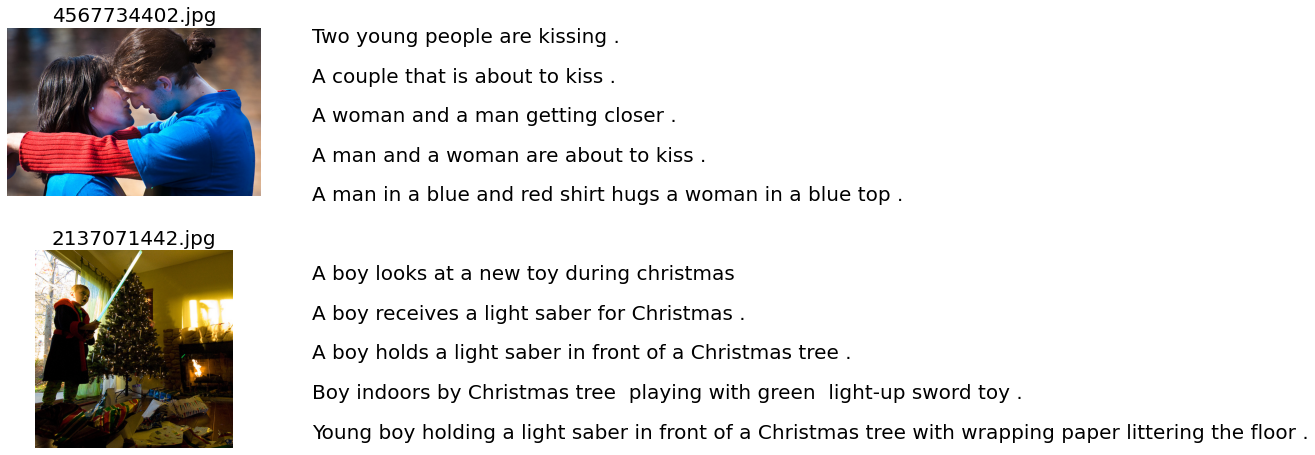

In [10]:
check_random_sample(2)

In [11]:
max_length = 0
for captions in data_dict.values():
    for caption in captions:
        if len(caption.split()) > max_length:
            max_length = len(caption.split())

print(max_length)

79


In [12]:
## generate train and test datasets
def generate_dataset(data, test_size, sample_size=None):
    if sample_size:
        max_keys = random.sample(data.keys(), sample_size)
        sample_size = int(test_size * sample_size)
        test_keys = random.sample(max_keys, sample_size)
        train_keys = [key for key in max_keys if key not in test_keys]
    else:
        sample_size = int(test_size * len(data))
        test_keys = random.sample(data.keys(), sample_size)
        train_keys = [key for key in data.keys() if key not in test_keys]
    
    test_captions = [(os.path.join(images_path, key), val) for key, val in data.items() if key in test_keys]
    train_captions = [(os.path.join(images_path, key), val) for key, val in data.items() if key in train_keys]
    print(f"Data split into {len(train_captions)} samples in train, {len(test_captions)} samples in test")

    train_raw = tf.data.experimental.from_list(train_captions)
    test_raw = tf.data.experimental.from_list(test_captions)
    return train_raw, test_raw

In [57]:
sample_size = 15000
test_size = 0.2

train_raw, test_raw = generate_dataset(data_dict, test_size, sample_size)

Data split into 12000 samples in train, 3000 samples in test


In [14]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'/content/drive/MyDrive/Capstone/flickr30k/flickr30k_images/10002456.jpg', shape=(), dtype=string)
tf.Tensor(
[b'Several men in hard hats are operating a giant pulley system .'
 b'Workers look down from up above on a piece of equipment .'
 b'Two men working on a machine wearing hard hats .'
 b'Four men on top of a tall structure .' b'Three men on a large rig .'], shape=(5,), dtype=string)


## Image Feature Extraction

In [15]:
image_shape = (224, 224, 3)

base_model = tf.keras.applications.MobileNetV3Small(
    include_top=False,
    include_preprocessing=True,
    input_shape=image_shape,
)

# Freeze the base_model
base_model.trainable = False

In [16]:
# function to load and resize image
def load_image(image_path):

    def parse(s):
        return s
    
    image_path = tf.py_function(parse, [image_path], (tf.string))
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_shape[:-1])
    return img

In [17]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(base_model(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


## Set Up Text Tokenizer

In [18]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [19]:
# Use the top 8,000 words for a vocabulary.
vocabulary_size = 8000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True
    )

In [20]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

In [22]:
test_caption = 'Two young guys with shaggy hair look at their hands while hanging out in the yard .'

In [23]:
caption_0_token = tokenizer(test_caption)
print(caption_0_token)

tf.Tensor(
[   3   14   21  349   12 2214  116  179   18   63  161   25  324   71
    5    6  499    4], shape=(18,), dtype=int64)


In [24]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [25]:
caption_0_word = index_to_word(caption_0_token)
tf.strings.reduce_join(caption_0_word, separator=' ', axis=-1).numpy()

b'[START] two young guys with shaggy hair look at their hands while hanging out in the yard [END]'

## Prepare Our Datasets

In [26]:
# ## reduce size for checking workflow
# def generate_sample(num):
#     idx = np.random.randint(0, len(all_captions), num)
#     all_image_names_samp = [all_image_names[i] for i in idx]
#     all_captions_samp = [all_captions[i] for i in idx]
#     return all_image_names_samp, all_captions_samp

In [27]:
# all_image_names_samp, all_captions_samp = generate_sample(10000)

In [28]:
# img_name_train, img_name_test, cap_train, cap_test = train_test_split(all_image_names_samp, all_captions_samp, test_size=0.2, random_state=rng)

# print(f'Data has been split into {len(img_name_train):,} samples in train and {len(img_name_test):,} samples in test.')

In [29]:
# train_raw = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
# test_raw = tf.data.Dataset.from_tensor_slices((img_name_test, cap_test))

In [30]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [31]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [32]:
def prepare_dataset(ds, tokenizer, batch_size=batch_size, shuffle_buffer=buffer_size):
  # Load the images and make batches.
  ds = (ds
        .shuffle(shuffle_buffer)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.Dataset.ignore_errors)
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [33]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [34]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions save_dataset and load_dataset:

In [35]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=batch_size):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.Dataset.ignore_errors)
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(buffer_size))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

In [36]:
def load_dataset(save_path, batch_size=batch_size, shuffle=buffer_size, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(buffer_size)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [37]:
save_dataset(train_raw, 'train_cache', base_model, tokenizer)
save_dataset(test_raw, 'test_cache', base_model, tokenizer)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Good reading on buffer size

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

# Check that we are optimising for GPU / TPU processing in Colab

- https://colab.research.google.com/notebooks/tpu.ipynb
- https://www.tensorflow.org/guide/distributed_training#tpustrategy

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. 

https://keras.io/guides/transfer_learning/

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model.
1. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
1. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
1. Train the new layers on your dataset.

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting include_top=False returns the model without the final classification layer, so you can use the last layer of feature-maps:

In [38]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [39]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [40]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [41]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


In [42]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [43]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


In [44]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

In [45]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


In [46]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

  0%|          | 0/1875 [00:00<?, ?it/s]


Uniform entropy: 8.99
Marginal entropy: 5.56


In [47]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=max_length, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [48]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [49]:
model = Captioner(tokenizer, feature_extractor=base_model, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [50]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

## Train

In [51]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

## Callbacks

In [52]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


In [53]:
early_stop = tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)

save_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='masked_acc',
        mode='max',
        verbose=1,
        initial_value_threshold=0.3,
        save_best_only=True)

In [54]:
callbacks = [
    GenerateText(),
    early_stop,
    save_checkpoint
    ]

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [61]:
steps = (sample_size * (1 - test_size)) / batch_size

history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=steps,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
375/375 [==============================] - ETA: 0s - loss: 3.6978 - masked_acc: 0.3362

a man in a red shirt is swimming in the water
a child in a red shirt is swimming
a toddler is body of water them of a pool


Epoch 1: masked_acc improved from 0.33443 to 0.33622, saving model to /tmp/checkpoint
375/375 [==============================] - 232s 615ms/step - loss: 3.6978 - masked_acc: 0.3362 - val_loss: 3.6553 - val_masked_acc: 0.3383
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 3.6938 - masked_acc: 0.3359

a man in a blue shirt is swimming in the water
the man is jumping over the water
a young male is jumping into a surfboard ride a pool


Epoch 2: masked_acc did not improve from 0.33622
375/375 [==============================] - 225s 600ms/step - loss: 3.6938 - masked_acc: 0.3359 - val_loss: 3.6214 - val_masked_acc: 0.3471
Epoch 3/100
375/375 [==============================] - ETA: 0s - loss: 3.6340 - masked_acc: 0.3402

a man in a blue shirt is s

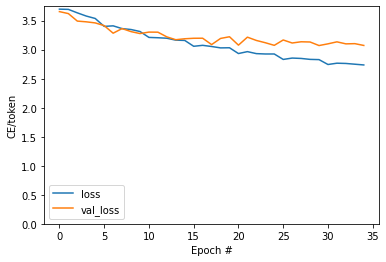

In [62]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

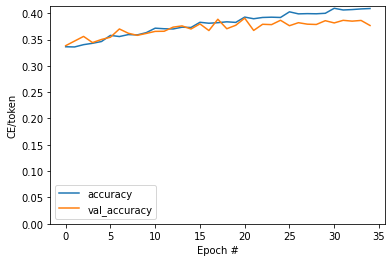

In [63]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [64]:
model.save(model_path)

In [77]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):

    def plot_attention_maps(image, str_tokens, attention_map):
        fig = plt.figure(figsize=(16, 9))

        len_result = len(str_tokens)
        
        titles = []
        for i in range(len_result):
            map = attention_map[i]
            grid_size = max(int(np.ceil(len_result/2)), 2)
            ax = fig.add_subplot(3, grid_size, i+1)
            titles.append(ax.set_title(str_tokens[i]))
            img = ax.imshow(image)
            ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                        clim=[0.0, np.max(map)])
            plt.axis("off")

        plt.tight_layout()

    result_txt = self.simple_gen(image, temperature)
    str_tokens = result_txt.split()
    str_tokens.append('[END]')

    attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
    attention_maps = tf.concat(attention_maps, axis=0)
    attention_maps = einops.reduce(
        attention_maps,
        'batch heads sequence (height width) -> sequence height width',
        height=7, width=7,
        reduction='mean')

    plot_attention_maps(image/255, str_tokens, attention_maps)
    t = plt.suptitle(result_txt)
    t.set_y(1.05)


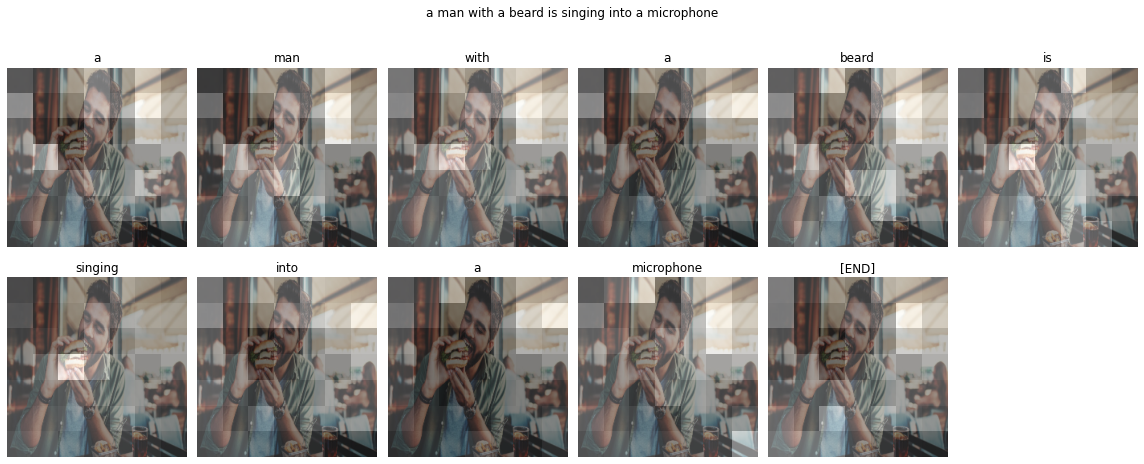

In [79]:
image_url = 'https://media.istockphoto.com/id/1045043934/photo/breakfast-in-a-cafe-food-lifestyle-concept.jpg?s=612x612&w=0&k=20&c=3LgAgp7S_1C5aX0mk94MmbmLQbi2W0z2MBN11wZo2M8='
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)

In [69]:
from google.colab import files
uploaded = files.upload()

Saving image-1.jpg to image-1.jpg
